# Projet 7 : Implémentez un modèle de scoring :Echantillonage

## Sommaire

 [1.Importation des données](#Int)  

 [2.LightGBM avant SMOTE](#Cha)

 [3.SMOTE et LightGBM](#Mod)



Le but de ce notebook est la mise en place des jeux d'entrainement et de test. On proposera aussi une première solution d'échantillonage et de réequilibrage des Datasets avec SMOTE.



<a name="Imt"></a>
# **Importation des données**

In [1]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 13.7 MB/s 


In [3]:
import numpy as np 
import pandas as pd

## PLOT
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

## Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from collections import Counter

##Split
from sklearn.model_selection import train_test_split

## Modelisation
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

## Scores
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_recall_fscore_support
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer

## feature importance
import shap

## Threshold
from yellowbrick.classifier.threshold import discrimination_threshold

## Export
import pickle

## Warning
import warnings

In [4]:
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning

In [5]:
warnings.filterwarnings("ignore")

In [6]:
use_colab = True 

if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    PATH ='/content/drive/MyDrive/'
else:
    PATH ='/data/'

Mounted at /content/drive


In [7]:
dataset = pd.read_csv(PATH + 'df_final.csv')

In [8]:
dataset.shape

(307511, 47)

In [9]:
train_len = dataset.shape[0]

In [10]:
train_dataset = dataset[:train_len]
train_ids = train_dataset['SK_ID_CURR']
train_dataset.drop(columns=['SK_ID_CURR'], axis = 1, inplace=True)

* Définir les features et la variable cible pour la modélisation

In [11]:
# separate training data
train_dataset['TARGET'] = train_dataset['TARGET'].astype(int)
target = train_dataset['TARGET']
features = train_dataset.drop(columns=['TARGET'], axis = 1)
print('x_train data shape: ', features.shape)
print('y_train data shape: ', target.shape)

x_train data shape:  (307511, 45)
y_train data shape:  (307511,)


In [12]:
target_sample = target
target_sample.shape

(307511,)

In [13]:
features_sample = features
features_sample.shape


(307511, 45)

* Le nombre des colonnes est : 45
* Le nombre des observations (lignes) est : 307511

<a name="Cha"></a>
# **LightGBM avant SMOTE**

###Preprocessing

Le prétraitement des données est le suivant:
* Fractionnement du jeu de données (40% test set).
* Définir les attributs (numériques , catégoriques ...)
* Compléter les données manquantes (Imputation):

Les variables numériques : Médiane (car variables asymétriques).
Les variables catégoriques : le plus fréquent.
* Mise à l'échelle des fonctionnalités (Robust scaler(plus fiable vis à vis des outliers)).
* Encodage des données catégorielles.


In [14]:
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(features_sample, target_sample, test_size = 0.4)

In [15]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123005 entries, 284149 to 10177
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           123005 non-null  object 
 1   CODE_GENDER                  123005 non-null  object 
 2   CNT_CHILDREN                 123005 non-null  int64  
 3   AMT_INCOME_TOTAL             123005 non-null  float64
 4   AMT_CREDIT_x                 123005 non-null  float64
 5   NAME_TYPE_SUITE              122503 non-null  object 
 6   NAME_INCOME_TYPE             123005 non-null  object 
 7   NAME_EDUCATION_TYPE          123005 non-null  object 
 8   NAME_FAMILY_STATUS           123005 non-null  object 
 9   REGION_POPULATION_RELATIVE   123005 non-null  float64
 10  DAYS_BIRTH                   123005 non-null  int64  
 11  DAYS_EMPLOYED                123005 non-null  int64  
 12  OWN_CAR_AGE                  41865 non-null   float64


In [16]:
X_test['DAYS_INSTALMENT_delay'] = X_test['DAYS_INSTALMENT_delay'].mul(-1)

In [17]:
X_train['DAYS_INSTALMENT_delay'] = X_train['DAYS_INSTALMENT_delay'].mul(-1)

In [18]:
pd.DataFrame(X_test).to_csv('/content/drive/MyDrive/X_test.csv',index=False)

In [19]:
# Define categorical columns
categoric_attribute = list(features_sample.select_dtypes(exclude=["number"]).columns)
# Define numerical columns
numeric_attribute = list(features_sample.select_dtypes(exclude=["bool_","object_"]).columns)


In [20]:
numeric_attribute

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_WORK_CITY',
 'TOTALAREA_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_CREDIT',
 'AMT_CREDIT_SUM',
 'AMT_BALANCE',
 'AMT_PAYMENT_CURRENT',
 'SK_DPD_x',
 'SK_DPD_DEF',
 'DAYS_INSTALMENT_delay',
 'AMT_INSTALMENT_delta',
 'AMT_ANNUITY',
 'AMT_CREDIT_y',
 'AMT_DOWN_PAYMENT',
 'DAYS_DECISION',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD_y']

In [21]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 414 kB/s 


In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
import category_encoders as ce

from category_encoders import TargetEncoder

encoder = LabelEncoder()

for col in categoric_attribute:
   X_train[col] = encoder.fit_transform(X_train[col])
   X_test[col] = encoder.fit_transform(X_test[col])

display(X_train)

,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,...,DAYS_DECISION,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_LAST_DUE,DAYS_TERMINATION,NAME_CONTRACT_STATUS,CODE_REJECT_REASON,NAME_CLIENT_TYPE,CNT_INSTALMENT_FUTURE,SK_DPD_y
36057,0,0,0,157500.0,270000.0,6,1,0,1,0.018209,...,-1363.000000,10.000000,365243.000000,181518.500000,181520.000000,0,7,1,6.000000,0.0
44915,0,0,0,112500.0,331632.0,6,1,1,0,0.022625,...,-789.000000,18.000000,365243.000000,121306.333333,121310.666667,0,7,2,12.333333,0.0
26132,0,0,0,119250.0,1170000.0,6,1,0,2,0.010147,...,NaN,NaN,NaN,NaN,NaN,4,9,4,NaN,NaN
223981,0,0,0,180000.0,942300.0,1,1,0,1,0.006852,...,-1763.000000,18.000000,181273.500000,-1027.000000,181948.000000,0,7,2,NaN,NaN
21303,0,0,0,292500.0,849415.5,6,1,0,2,0.008019,...,-1180.444444,27.111111,312944.428571,51501.285714,51506.000000,0,7,2,24.075472,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20485,0,0,0,90000.0,508500.0,6,1,1,0,0.010500,...,-392.714286,37.500000,365243.000000,121508.666667,121513.333333,0,7,2,19.333333,0.0
18486,0,0,0,180000.0,835380.0,6,1,1,0,0.018801,...,-1299.727273,26.400000,365243.000000,-1303.750000,-1299.125000,0,7,2,20.500000,0.0
189542,1,0,1,135000.0,360000.0,6,1,1,2,0.018634,...,-1515.600000,25.200000,365243.000000,120807.666667,120812.333333,0,7,2,49.500000,0.0
131115,0,0,2,157500.0,640080.0,6,1,1,0,0.019101,...,-318.000000,18.000000,365243.000000,-160.000000,-155.000000,0,7,0,12.600000,0.0


In [24]:
# Pipeline data transformation (Imputation / Scaling / Encoding):
def Preprocessing (numeric):
    numeric_transfs = [('imputer',SimpleImputer(missing_values= np.NAN, strategy= 'median')),('scaler', RobustScaler())]
    numeric_pipeline = Pipeline(numeric_transfs)
    all_transfs = [("numeric",numeric_pipeline,numeric)]
    full_preprocessor = ColumnTransformer(all_transfs, remainder='passthrough')
    return full_preprocessor

In [25]:
y_test.shape[0]

123005

In [26]:
# Data Transformed
preprocessor_fitted = Preprocessing(numeric_attribute).fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184506 entries, 36057 to 207593
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           184506 non-null  int64  
 1   CODE_GENDER                  184506 non-null  int64  
 2   CNT_CHILDREN                 184506 non-null  int64  
 3   AMT_INCOME_TOTAL             184506 non-null  float64
 4   AMT_CREDIT_x                 184506 non-null  float64
 5   NAME_TYPE_SUITE              184506 non-null  int64  
 6   NAME_INCOME_TYPE             184506 non-null  int64  
 7   NAME_EDUCATION_TYPE          184506 non-null  int64  
 8   NAME_FAMILY_STATUS           184506 non-null  int64  
 9   REGION_POPULATION_RELATIVE   184506 non-null  float64
 10  DAYS_BIRTH                   184506 non-null  int64  
 11  DAYS_EMPLOYED                184506 non-null  int64  
 12  OWN_CAR_AGE                  62717 non-null   float64


In [28]:
X_test_transformed.shape

(123005, 45)

* Nombre des colonnes après encodage : 45
* Nombre des observations dans la fraction train : 184506
* Nombre des observations dans la fraction train : 123005

### LightGBM avant SMOTE

Avant SMOTE, en raison du désequilibre dans les classes, le F1 Score est très faible ce qui n'est pas surprenant, on va donc d'abord réequilibrer les classes en utilisant SMOTE.

In [29]:
from lightgbm import LGBMClassifier

In [31]:
# generate predictions with the random forest classifier
rfc = LGBMClassifier(random_state=42)
rfc.fit(X_train_transformed, y_train)
y_pred = rfc.predict(X_test_transformed)

In [32]:
from sklearn.metrics import f1_score
import numpy as np

# compute the f-1 score
f1 = np.round(f1_score(y_test, y_pred),2)
print('F-1 score of model without SMOTE: {}'.format(f1))

F-1 score of model without SMOTE: 0.01


<a name="Mod"></a>
# **Smote et LightGBM**

* Le sous-échantillonnage aléatoire (random undersampling) des observations majoritaires :  on retire aléatoirement des observations majoritaires
* Le sur-échantillonnage aléatoire (random oversampling) des observations minoritaires :  on tire au hasard des individus minoritaires que l’on rajoute aux données. 
* Le sur-échantillonnage synthétique (SMOTE pour Synthetic Minority Oversampling Technique) produit des observations minoritaires ressemblantes mais distinctes de celles déjà existantes.

L'idée est de combiner SMOTE avec une technique de sous-échantillonnage (ENN, Tomek) pour augmenter l'efficacité de la gestion de la classe déséquilibrée.

In [62]:
from imblearn.under_sampling import TomekLinks

tl = RandomUnderSampler(sampling_strategy=0.9)

# fit predictor and target variable
X_train_smtomek, y_train_smtomek = tl.fit_resample(X_train_transformed, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_smtomek))

Original dataset shape Counter({0: 169563, 1: 14943})
Resample dataset shape Counter({0: 16603, 1: 14943})


In [39]:
from imblearn.over_sampling import SMOTE


In [45]:
from sklearn.utils import resample

In [ ]:
# define smote strategy
#sm = SMOTE(random_state=42)
#smtomek=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

In [ ]:
#def resampling (features, target, resample):
#    print('Original dataset shape %s' % Counter(target))
#    X, y = resample.fit_resample(features, target)
#   print('Resampled dataset shape %s' % Counter(y))
#    return X, y

In [46]:
#X_train_smtomek,y_train_smtomek = resampling (X_train_transformed, y_train, smtomek)

NameError: ignored

In [63]:
rfc.fit(X_train_smtomek, y_train_smtomek)
y_pred_smote = rfc.predict(X_test)

# compute the f-1 score
f1_smote = round(f1_score(y_test, y_pred_smote),2)
print('F1-score of model with SMOTE: {}'.format(f1_smote))

F1-score of model with SMOTE: 0.15


In [49]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [64]:
print(f'Accuracy: {accuracy_score(y_test, rfc.predict(X_test_transformed))}')
print(f'Precision: {precision_score(y_test, rfc.predict(X_test_transformed))}')
print(f'Recall: {recall_score(y_test, rfc.predict(X_test_transformed))}')

Accuracy: 0.6963456770049998
Precision: 0.1533180200419012
Recall: 0.6146529042703907


In [51]:
y_pred=rfc.predict(X_test_transformed)

In [65]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[79333 33790]
 [ 3781  6101]]

True Positives(TP) =  79333

True Negatives(TN) =  6101

False Positives(FP) =  33790

False Negatives(FN) =  3781


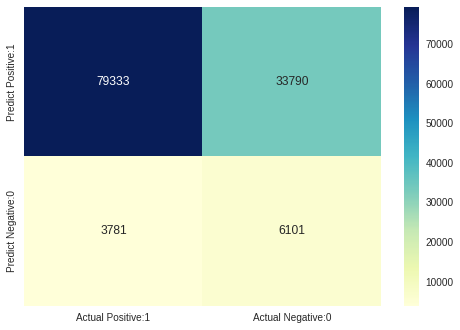

In [53]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [54]:
from sklearn import metrics

In [55]:
auc_roc=metrics.roc_auc_score(y_test,y_pred)
auc_roc

0.659341865600948

In [56]:
y_prob = rfc.predict_proba(X_test_transformed)[:,1] 

In [57]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7169968203588264

Text(0.5, 0, 'False Positive Rate')

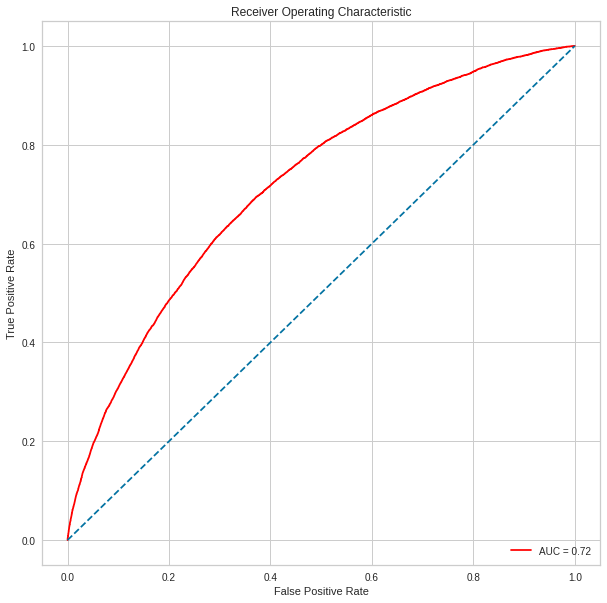

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

On voit ici que le score est déjà plus acceptable et que le Fbeta score est le plus élevé avec Beta étant égal à 40, ce qui nous indique que la mesure la plus importante est le rappel, appelé aussi Recall en anglais. Il faut donc se concentrer sur les faux-négatifs.

Text(0.5, 1.0, 'Fbeta scores with beta 0 to 100')

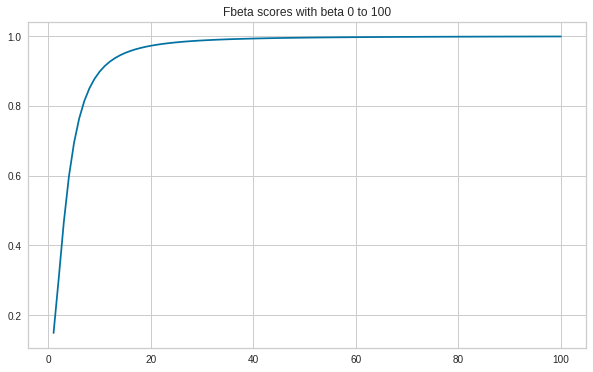

In [59]:
beta_score_list = []
for i in range(1,101):
    fbeta_results = fbeta_score(y_test,y_pred_smote,beta=i)
    beta_score_list.append(fbeta_results)
fig2 = plt.figure(figsize=(10,6))
sns.lineplot(x=range(1,101),y=beta_score_list)
plt.title("Fbeta scores with beta 0 to 100")

In [ ]:
#X_test_smtomek,y_test_smtomek = resampling (X_test_smote, y_test_smote)

Pour conclure, afin d'optimiser notre algorithme, on va réequilibrer les classes sans utiliser SMOTE mais en utilisant les paramètres de LightGBM avec Weight POS, ce qu'on verra dans le notebook suivant.

On exporte ensuite les Datasets pour les réutiliser dans les autres notebooks

In [66]:
pd.DataFrame(X_train_smtomek).to_csv('/content/drive/MyDrive/X_train_smtomek.csv',index=False)
pd.DataFrame(y_train_smtomek).to_csv('/content/drive/MyDrive/y_train_smtomek.csv',index=False)

In [68]:
pd.DataFrame(X_test_transformed).to_csv('/content/drive/MyDrive/X_test_smtomek.csv',index=False)
pd.DataFrame(y_test).to_csv('/content/drive/MyDrive/y_test_smtomek.csv',index=False)